## Use ARIMA model,  Dickey-Fuller test and Granger causality test to analyze historical shipment

### import modules and file path , dataframe settings 

In [1]:
import pandas as pd
import os
from pathlib import Path
import glob
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# filepath settings
home = str(Path.home())
filepath = glob.glob(os.path.join(home, 'desktop','ltf.xlsx'))

In [3]:
df = pd.read_excel(filepath[0])

df_filtered = df.loc[df['QTY ID'] == 'Consumption']

df_group = df_filtered.groupby('Plan Week')[['QTY']].sum().reset_index()

df_group['Plan Week'] = pd.to_datetime(df_group['Plan Week']).dt.date

df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Plan Week  61 non-null     object
 1   QTY        61 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


### An overview of historical shipment

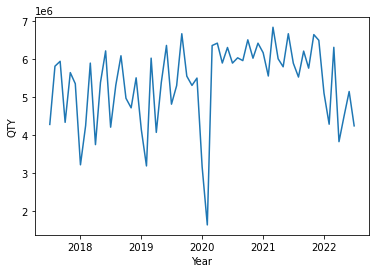

In [4]:
plt.plot(df_group['Plan Week'],df_group['QTY'])
plt.xlabel("Year")
plt.ylabel("QTY") 
plt.show()

arima_data = df_group['QTY']

### Use seasonal_decompose from statsmodel to determine features for time series

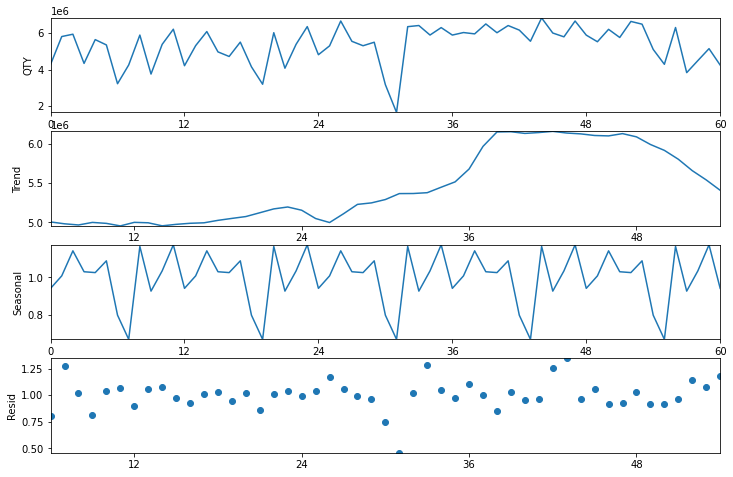

In [5]:
result = seasonal_decompose(arima_data, model="multiplicative", period=12)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed, label="Shipment")
plt.ylabel("QTY")
plt.xticks(df_group.index[::12], rotation=0) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
plt.xticks(df_group.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
plt.xticks(df_group.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,4)
plt.scatter(df_group.index,result.resid);
plt.ylabel("Resid")
plt.xticks(df_group.index[::12], rotation=0)
plt.margins(0)

### Perform Dickey-Fuller test to determine if the data is stationary and if differencing is needed

In [6]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                 -3.151953
p-value                         0.022940
#Lags Used                      3.000000
Number of Observations Used    57.000000
Criterical Value (1%)          -3.550670
Criterical Value (5%)          -2.913766
Criterical Value (10%)         -2.594624
dtype: float64
The data is stationary. (Criterical Value 5%)


### Import ACF and PACF to determine p, q for ARIMA model

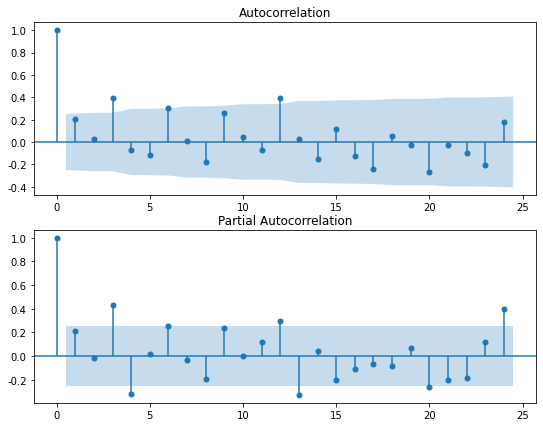

In [7]:
#correlogram
f = plt.figure(facecolor="white", figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1);
ax2 = f.add_subplot(212);
plot_pacf(arima_data, lags=24, ax=ax2);
plt.rcParams["axes.unicode_minus"] = False 
plt.show()

### Import Arima Model with  p=4, q =1

In [19]:
# 1,1,2 ARIMA Model
model = ARIMA(arima_data, order=(4,1,1))
model_fit = model.fit(disp=0)
model_fit.summary()

C:\Users\hout\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hout\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\hout\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.QTY   No. Observations:                   60
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -908.745
Method:                       css-mle   S.D. of innovations         882122.345
Date:                Thu, 27 Oct 2022   AIC                           1831.490
Time:                        15:26:15   BIC                           1846.150
Sample:                             1   HQIC                          1837.224
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.347e+04   9316.056      1.446      0.148   -4788.617    3.17e+04
ar.L1.D.QTY     0.3358      0.122      2.759      0.006       0.097       0.574
ar.L2.D.QTY    -0.1632      0.118     -1.379      0.168      -0.395       0.069
ar.L3.D.QTY     0.4506      0.117      3.862      0.000       0.222       0.679
ar.L4.D.QTY    -0.3333      0.128     -2.612      0.009      -0.583      -0.083
ma.L1.D.QTY    -1.0000      0.062    -16.158      0.000      -1.121      -0.879
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5987           -1.0211j            1.1837           -0.3344
AR.2           -0.5987           +1.0211j            1.1837            0.3344
AR.3            1.2748           -0.7187j            1.4634           -0.0817
AR.4            1.2748           +0.7187j            1.4634            0.0817
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### Checking for Residual Values

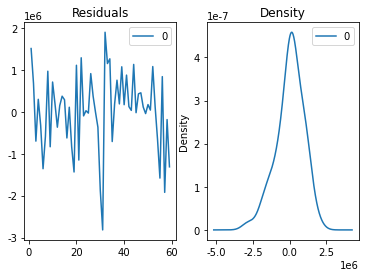

In [56]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Fitted the model into historical shipment for checking

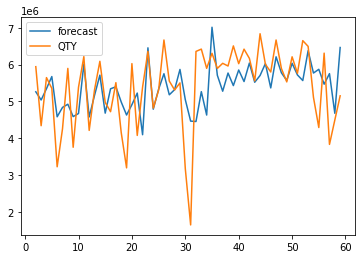

In [57]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()